# Context
(describe the experiment or data collection, link to relevant data, notes, and documentation)

Data processing associated with [Stefan's data collection](https://egnyte.nhgh.org/app/index.do#storage/folder/e33965e7-ed7d-4192-aebe-8126386af5d5) done on Aug 24, 2023, where the goal is to characterise the SNR of the new pressure sensor. The new pressure sensor tested is [SDP810-125PA](https://www.digikey.com/en/products/detail/sensirion-ag/SDP810-125PA/6605488), purchased on digikey.

`timestamps.xlsx` is a manually annotated file with timestamp information corresponding to the data collection.

## Experiment Assumptions
Natural breathing is assumed (~14 breaths per minute for this adult male subject). RR algorithm evaluation uses seed as 20 breaths per minute to minimize the effect of the seed. Otherwise, setting the seed to 15 breaths per minute results in better than expected performance.

## Parameters
* Background (no movement)
* shallow breathing, normal rate
* shallow breathing, faster rate
* normal breathing, normal rate
* normal breathing, faster rate
  

## Equipment Used
* pressure sensor


In [60]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from ppg2rr import signal_quality as sqi
from ppg2rr import util, riv_est
from ppg2rr.rr_est import estimate_rr_single_frame

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Update me
exp_directory = '../data/bench/20230824 New pressure sensor/'

# Load Data & Time-Sync

In [63]:

# manual annotations with timings and parameters
timing_df = pd.read_excel(f'{exp_directory}/timestamps.xlsx')
timing_df['duration'] = timing_df['End BMA']-timing_df['Start BMA']

In [64]:
timing_df.columns

Index(['Run', 'Start BMA', 'End BMA', 'Mask', 'Depth', 'Rate', 'duration'], dtype='object')

In [65]:
# Update me
param_columns = ['Run','Mask', 'Depth', 'Rate']

## NH Custom Hardware

In [66]:
# Update me
bma_filename = "BMA400_2023-08-24_11-32-42"
bma_filename_split = bma_filename.split('_')
bme_timestamp = bma_filename_split[1] + ' ' + bma_filename_split[2].replace('-',':')
# put in format like '2023-08-24 11:32:42'

In [67]:
df = pd.read_csv(f'{exp_directory}/{bma_filename}.csv')
df['ppg'] = -df['ppg'] # flip ppg direction to get the appropriate shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85917 entries, 0 to 85916
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ppg_counter           85917 non-null  int64  
 1   ppg_us                85917 non-null  int64  
 2   ppg_agc_stable        85917 non-null  int64  
 3   ppg_led_drive_levels  85917 non-null  int64  
 4   ppg                   85917 non-null  int64  
 5   ppg_in_waiting        85917 non-null  int64  
 6   x1                    85917 non-null  float64
 7   y1                    85917 non-null  float64
 8   z1                    85917 non-null  float64
 9   x2                    85917 non-null  float64
 10  y2                    85917 non-null  float64
 11  z2                    85917 non-null  float64
 12  force                 85917 non-null  float64
 13  ser1.in_waiting       85917 non-null  int64  
 14  pressure              85917 non-null  float64
 15  pressure_clock_ms  

In [68]:
# add timestamp & param info to the main data file
df = df.assign(run=None,note=None)
for idx, row in timing_df.iterrows():
    selector = df['elapsed_time_ms'].between(row['Start BMA']*1000,row['End BMA']*1000)
    for col in param_columns:
        df.loc[selector,col] =  row[col]

# datetime is estimated using the filename
df['datetime'] = pd.to_datetime(bme_timestamp) + pd.to_timedelta(df['elapsed_time_ms'], unit='ms')

In [69]:
df = df.fillna(np.nan)
df.sample(10)

,ppg_counter,ppg_us,ppg_agc_stable,ppg_led_drive_levels,ppg,ppg_in_waiting,x1,y1,z1,x2,...,pressure_clock_ms,ser2.in_waiting,elapsed_time_ms,run,note,Run,Mask,Depth,Rate,datetime
48085,19084,2060789520,1,4,-1428204,0,0.019,-0.021,1.001,-0.174,...,192390,0,194958.156,NaN,NaN,6.0,on,Shallow,Normal,2023-08-24 11:35:56.958156
73788,44787,2163596462,1,4,-1428305,0,0.018,-0.021,1.000,-0.172,...,295133,0,297765.976,NaN,NaN,9.0,on,normal,faster,2023-08-24 11:37:39.765976
65725,36724,2131346049,1,4,-1428208,0,0.018,-0.021,1.000,-0.173,...,262892,0,265515.239,NaN,NaN,8.0,on,shallow,Faster,2023-08-24 11:37:07.515239
45693,16692,2051221991,1,4,-1428402,0,0.018,-0.022,1.000,-0.175,...,182799,0,185390.532,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-24 11:35:47.390532
66293,37292,2133617937,1,4,-1428291,0,0.018,-0.021,0.999,-0.172,...,265238,0,267787.106,NaN,NaN,8.0,on,shallow,Faster,2023-08-24 11:37:09.787106
22494,59029,1958430557,1,4,-1428756,0,0.017,-0.021,0.999,-0.174,...,89955,0,92657.125,NaN,NaN,3.0,off,NaN,NaN,2023-08-24 11:34:14.657125
38974,9973,2024347313,1,4,-1428477,0,0.018,-0.021,0.999,-0.174,...,155863,0,158515.663,NaN,NaN,5.0,on,normal,Faster,2023-08-24 11:35:20.515663
31433,2432,1994184797,1,4,-1428550,0,0.018,-0.021,1.001,-0.172,...,125765,0,128409.310,NaN,NaN,4.0,on,Shallow,Faster,2023-08-24 11:34:50.409310
19778,56313,1947567092,1,4,-1428752,0,0.018,-0.022,1.000,-0.174,...,79042,0,81790.262,NaN,NaN,2.0,on,normal,normal,2023-08-24 11:34:03.790262
41261,12260,2033494863,1,4,-1428401,0,0.018,-0.021,0.999,-0.174,...,165046,0,167663.247,NaN,NaN,5.0,on,normal,Faster,2023-08-24 11:35:29.663247


In [70]:
smoothed_pressure = signal.medfilt(df['pressure'],75)
df['smoothed_pressure'] = smoothed_pressure

# Visualize Data

In [71]:
# helper function to visualize data

# these colors are nice:'#FF7E00','#03C03C','#B31B1B'

def make_figure(df_all, target, subset=None, start=None, fs=250, duration=30, legend=True, show=True):
    """
    Args:
        subset: boolean array to select a subset of df_all
        target: target column to display
        start: index to zoom in on, seconds
        fs: sampling frequency, Hz
        duration: together with "start" and "fs", sets the the x axis limit.
        
    Returns:
        ppg array specified with subset
    """

    
    if subset is not None:
        subset = df_all['datetime'].between(
            df_all.loc[subset,'datetime'].iloc[0],
            df_all.loc[subset,'datetime'].iloc[-1]
            )
        df = df_all[subset]
    else:
        df = df_all
        
    if show:
        plt.figure(figsize=(15,5))
        plt.plot(df[target],color="#8870ff", linewidth=0.5)
        
        # plot individual runs
        runs = timing_df['Run'].unique()
        for run in runs:
            label = ""
            for col in param_columns:
                label += f"{col}: {timing_df.loc[timing_df['Run']==run,col].iloc[0]}, "
            label = label.strip()
            plt.plot(df[(df['Run']==run)][target], label=label)

        plt.ylabel(target)

        if legend:
            # legend proxies   
            # plt.plot([], label = 'no motion; normal breathing', color='#1F75FE')
            plt.legend()
        
        if start is not None:
            frame_len = fs*duration
            end = start*fs + frame_len
            plt.xlim(start*fs,end)
            
        
        plt.show()
    
    return df[target]

In [72]:
# use "subset" to view specific runs, or remove the argument to see the entire file
run = 0
subset = (df['Run'] == run)
nh_subset = df['datetime'].between(min(df.loc[subset,'datetime']),max(df.loc[subset,'datetime']))
fig = px.line(y=df[nh_subset]['ppg'], title='NH hardware')
fig.show()


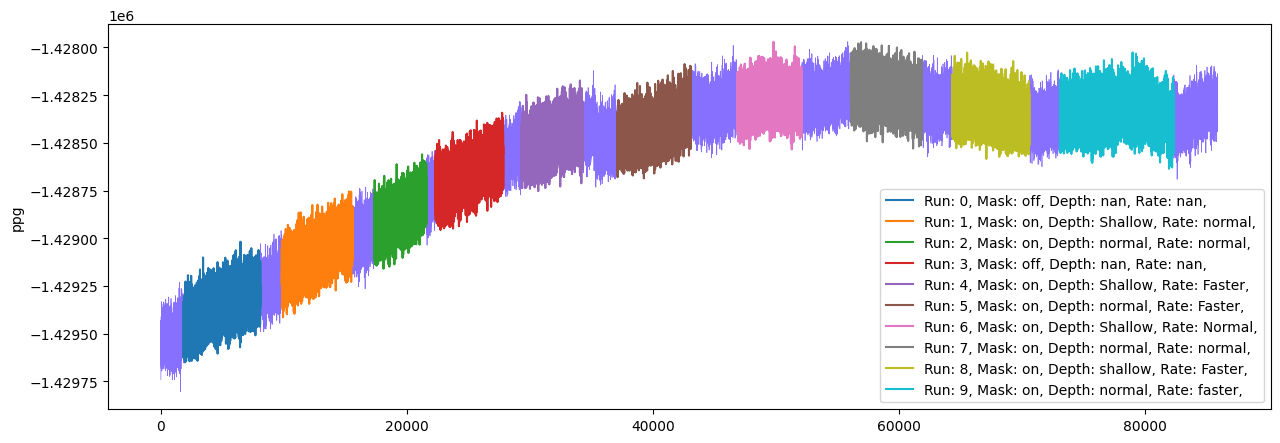

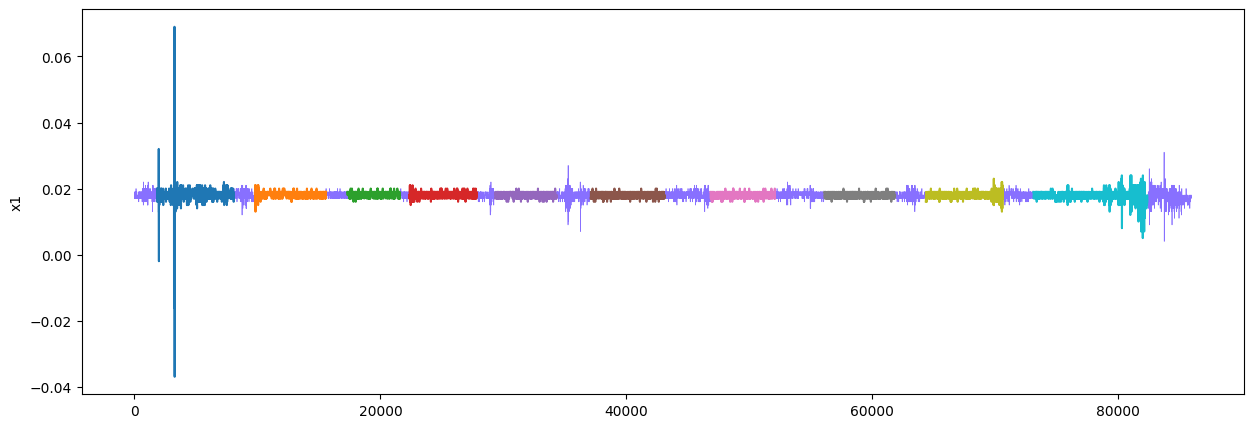

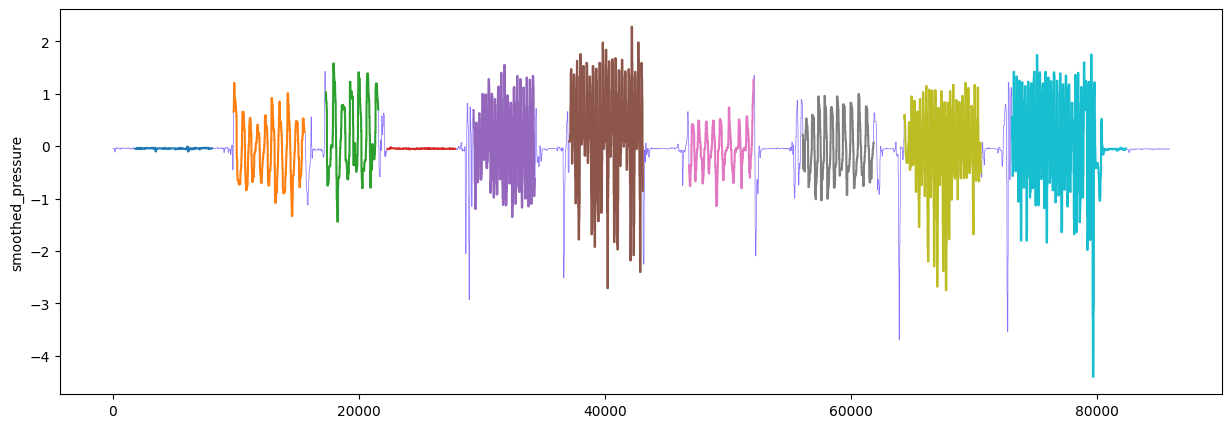

In [76]:
# NH custom hardware - BMA
# run = [1,2]
# subset = (df['Run'].isin(run)) # view data from a specific run

# adjust start, duration, and subset to view different segments
# start = 30
subset = None
# duration = 60
start=None
# start=None
duration = 60

ppg_nh = make_figure(df,'ppg',subset=subset,start=start,duration=duration, legend=True)
accel = make_figure(df,'x1',subset=subset,start=start,duration=duration, legend=False)
_ = make_figure(df,'smoothed_pressure',subset=subset,start=start,duration=duration, legend=False)

## Compare PPG waveforms across 2 devices

In [ ]:
# Plot PPG waveform and estimate RR

def standardize(data):
    return (data-np.mean(data))/np.std(data)

runs = np.arange(0,10)
valid_run = []
run_label = []
rr_est1 = []
rr_est2 = []

for run in runs:
    # make axes and plot figures
    subset = (df['Run'] == run)
    nh_subset_ppg = df[subset]['ppg']
    
    x_nh = np.arange(0,len(nh_subset_ppg))/250
    title = f"""
    run: {run}, Motion: {timing_df[timing_df['Run']==run]['Note'].iloc[0]}
    """
    
    plt.figure(figsize=(12,5))
    plt.plot(x_nh,standardize(nh_subset_ppg)-5, label = 'NH Custom Hardware')
    plt.title(title)
    plt.legend()
    plt.show()
    
    # Also do RR estimation with algorithm
    labels = ['NH Custom']
    ppgs = [nh_subset_ppg]
    fss = [250]
    for ppg,fs,label in zip(ppgs,fss,labels):
        # ppg_lp = util.lowpass_butter(ppg,250,5/60)
        # ppg_hp = ppg-ppg_lp
        (
        rr_candidate_merged,
        all_rr_candidates,
        feature_quality,
        ) = estimate_rr_single_frame(
            ppg=ppg,
            fs_ppg=fs,
            hr_est=70,
            rr_max=70/1.75,
            min_resp_freq=4/60,
            rr_est=10,
            remove_riv_outliers=None,
            fs_riv=20,
            n_sig=3,
            show=False,
        )
            
        valid_run.append(run)
        run_label.append(label)
        rr_est1.append(rr_candidate_merged['kalman'])
        rr_est2.append(rr_candidate_merged['simple median'])
                
results_df = pd.DataFrame({
    "run":valid_run,
    "hardware":run_label,
    "kalman est":rr_est1,
    "simple median est": rr_est2,
})

In [ ]:
results2 = results_df.pivot(index='Run',columns='hardware',values=['kalman est','simple median est'])
results2

In [ ]:
results2.to_csv(f'{exp_directory}/evaluation_results_accel_test_20230814.csv')

In [ ]:
# Manually pull out figures for presentation
subset = (df['Run']==6) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)
plt.plot(ppg_nh, color="#B31B1B")
# plt.ylim([-.85,-.6])

# Save data if desired
# nh_subset_ppg.to_csv('ppg_example.csv', index=False)

In [ ]:
subset = (df['Run']==5) # view data from a specific run
ppg_nh = make_figure(df,'ppg',subset=subset,legend=False, show=False)

(
rr_candidate_merged,
all_rr_candidates,
feature_quality,
) = estimate_rr_single_frame(
    ppg=ppg_nh.values,
    fs_ppg=250,
    hr_est=70,
    rr_max=70/1.75,
    min_resp_freq=4/60,
    rr_est=20,
    remove_riv_outliers=None,
    fs_riv=10,
    n_sig=3,
    show=False,
)

rr_candidate_merged

# Calculate SNR

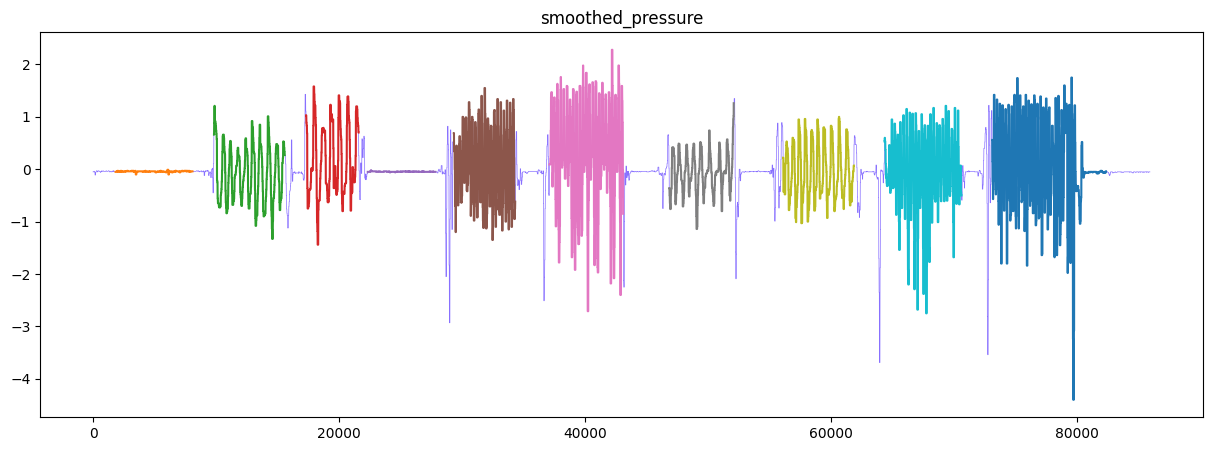

In [78]:
plt.figure(figsize=(15,5))
plt.plot(df['smoothed_pressure'],color="#8870ff", linewidth=0.5)
for run in df['Run'].unique():
    plt.plot(df[df['Run']==run]['smoothed_pressure'])
plt.title('smoothed_pressure')
plt.show()

In [79]:
timing_df

,Run,Start BMA,End BMA,Mask,Depth,Rate,duration
0,0,10,35,off,NaN,NaN,25
1,1,42,65,on,Shallow,normal,23
2,2,72,89,on,normal,normal,17
3,3,92,114,off,NaN,NaN,22
4,4,120,140,on,Shallow,Faster,20
5,5,151,175,on,normal,Faster,24
6,6,190,211,on,Shallow,Normal,21
7,7,227,250,on,normal,normal,23
8,8,260,285,on,shallow,Faster,25
9,9,295,332,on,normal,faster,37


In [80]:
# calculate SNR
target_signal = 'smoothed_pressure'

def power(arr):
    # power is equivalent to the mean-squared signal
    arr_centered = arr - np.mean(arr) #remove bias first
    squared_arr = np.square(arr_centered)
    return np.mean(squared_arr)

background_runs = df['Run'].isin([0,3])
p_noise = power(df[background_runs][target_signal])

selectors = {
    'Shallow':df['Run'].isin([1,4,6,8]),
    'Normal':df['Run'].isin([2,5,7,9]),
}

conditions = []
snrs = []
for condition, selector in selectors.items():
    runs = df[selector]['Run'].unique()
    for run in runs:
        isolated_signal = df[selector & (df['Run']==run)][target_signal]
        p_signal = power(isolated_signal)
        snr_db = 10*np.log10(p_signal/p_noise)
        
        conditions.append(condition)
        snrs.append(snr_db)

print(f'SNR (dB) for {target_signal}')
snr_df = pd.DataFrame({'condition':conditions,'snr (dB)':snrs})
snr_df.groupby('condition').agg(['mean', 'std'])

SNR (dB) for smoothed_pressure


snr (dB)          
                mean       std
condition                     
Normal     38.978731  2.740576
Shallow    36.830642  3.144991